<a href="https://colab.research.google.com/github/zeroxenator/rug-ltp-project/blob/master/SentimentAnalysis_Using_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparing Data**

In [0]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [3]:
print(len(train_data))
print(len(test_data))

25000
25000


In [4]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(len(train_data))
print(len(valid_data))

17500
7500


### Word Embeddings

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [6]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))
print(train_data[0].text)
print(train_data[0].label)
print(train_data[0])

17500
7500
25000
['This', 'show', 'is', 'terrible', ',', 'the', 'jokes', 'are', 'all', 'terrible', 'and', 'just', 'getting', 'worse', 'and', 'worse', '.', 'I', 'am', 'one', 'of', 'those', 'people', 'who', 'was', 'never', 'a', 'big', 'fan', 'of', 'Corner', 'Gas', 'but', 'at', 'least', 'I', 'liked', 'it', 'at', 'first', 'until', 'it', 'got', 'into', 'a', 'rut', 'around', 'season', 'two', ',', 'all', 'the', 'jokes', 'had', 'been', 'played', 'out', 'and', 'the', 'characters', 'had', 'nothing', 'to', 'them', '.', 'Well', 'at', 'least', 'Corner', 'Gas', 'was', 'good', 'at', 'first', ',', 'Little', 'Mosque', 'on', 'the', 'Prairie', 'is', 'typically', 'awful', 'bland', 'CBC', 'comedy', 'that', 'had', 'nothing', 'going', 'for', 'it', 'from', 'episode', '1', '.', 'Who', 'are', 'the', 'people', 'who', 'are', 'watching', 'this', 'show', 'anyway', ',', 'I', 'am', 'being', 'honest', 'is', 'it', 'old', 'people', 'or', 'maybe', 'just', 'people', 'who', 'actually', 'live', 'on', 'the', 'prairies', '?',

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [0]:
print(len(train_iterator))
print(len(valid_iterator))
print(len(test_iterator))

for batch in train_iterator:
  
  print('------TEXT------')
  print(len(batch))
  print(len(batch.text)) #--> 2: [0] is text, [1] is textlength
  
  print(len(batch.text[0][0]))
  
  print('------LABELS------')
  print(batch.label)
  print(batch.label.shape)
  break


274
118
391
------TEXT------
64
2
64
------LABELS------
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
torch.Size([64])


# Build the Model

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))

In [9]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

print("INPUT_DIM:", INPUT_DIM)
print("PAD_IDX:", PAD_IDX)

INPUT_DIM: 25002
PAD_IDX: 1


In [0]:
model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


The final addition is copying the pre-trained word embeddings we loaded earlier into the embedding layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, **[vocab size, embedding dim**]

In [12]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [13]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.4193,  0.6715, -0.5205,  ..., -0.7538, -0.0051,  0.6917],
        [ 0.3391, -0.0290,  0.4831,  ..., -0.6991, -0.2370,  0.2094],
        [ 0.0944, -0.1442, -0.1443,  ..., -0.4783, -0.6824,  0.1593]])

As our \<unk> and \<pad> token aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

In [14]:

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.4193,  0.6715, -0.5205,  ..., -0.7538, -0.0051,  0.6917],
        [ 0.3391, -0.0290,  0.4831,  ..., -0.6991, -0.2370,  0.2094],
        [ 0.0944, -0.1442, -0.1443,  ..., -0.4783, -0.6824,  0.1593]])


# Train the Model

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import f1_score

def f1_score_custom(preds, labels):
  
    y_pred = torch.round(torch.sigmoid(preds))
        
    f1 = f1_score(y_pred.cpu().detach().numpy(), labels.cpu().detach().numpy())
    
    return f1

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def confusion_matrix_custom(preds, labels, normalize=False):
    y_pred = torch.round(torch.sigmoid(preds))
    
    # Compute confusion matrix
    cm = confusion_matrix(labels.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return cm


In [0]:
def plot_confusion_matrix(cm,
                          normalize=False, 
                          save=False,
                          filename='cm.png',
                          cmap=plt.cm.Blues):
  
    title = ''
    classes = ['neg', 'pos']
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' #if normalize else 'd'
    
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    if save:
      plt.savefig(filename)
    
    plt.show()

    return ax

In [0]:
import matplotlib.pyplot as plt

def loss_graph(phase, epochs, loss_hist, save=False, filename='loss_graph.png'):
  
    plt.figure(figsize=(10,5))
  
    plt.title("{0} Loss vs. Number of Training Epochs".format(phase))
    plt.xlabel("Training Epochs")
    plt.ylabel("{0} Loss".format(phase))
    
    x = range(1, epochs+1)
    y = loss_hist
    
    plt.plot(x, y, marker=5)

    plt.ylim((0, 1.))
    plt.xticks(np.arange(1, epochs+1, 1.0))
    
    plt.grid(True)
    
    if save:
      plt.savefig(filename)
    
    plt.show() 

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_cm = np.zeros((2,2))
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        f1 = f1_score_custom(predictions, batch.label)
        
        cm = confusion_matrix_custom(predictions, batch.label, normalize=False)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1
        epoch_cm = np.add(epoch_cm, cm)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator), epoch_cm

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_cm = np.zeros((2,2))
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            
            f1 = f1_score_custom(predictions, batch.label)
            
            cm = confusion_matrix_custom(predictions, batch.label, normalize=False)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_cm = np.add(epoch_cm, cm)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator), epoch_cm

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 5

best_valid_loss = float('inf')

train_loss_hist = []
valid_loss_hist = []

train_cm = []
valid_cm = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()
    
    train_loss, train_acc, train_f1, train_cm = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_cm = evaluate(model, valid_iterator, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}  |  Train F1: {train_f1*100:.2f} %')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}  | . Val. F1: {valid_f1*100:.2f} %')

Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 0.676 | Train Acc: 58.55  |  Train F1: 54.43 %
	 Val. Loss: 0.684 |  Val. Acc: 53.01  | . Val. F1: 23.00 %
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.683 | Train Acc: 56.31  |  Train F1: 50.49 %
	 Val. Loss: 0.672 |  Val. Acc: 61.95  | . Val. F1: 66.64 %
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.646 | Train Acc: 62.80  |  Train F1: 60.41 %
	 Val. Loss: 0.607 |  Val. Acc: 64.60  | . Val. F1: 68.39 %
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.655 | Train Acc: 62.33  |  Train F1: 58.77 %
	 Val. Loss: 0.650 |  Val. Acc: 60.05  | . Val. F1: 43.96 %
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.610 | Train Acc: 66.84  |  Train F1: 63.59 %
	 Val. Loss: 0.538 |  Val. Acc: 73.71  | . Val. F1: 71.95 %


## Metrics

Graph the Loss vs Epochs

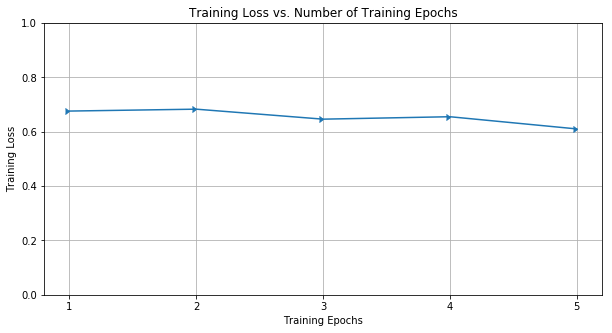

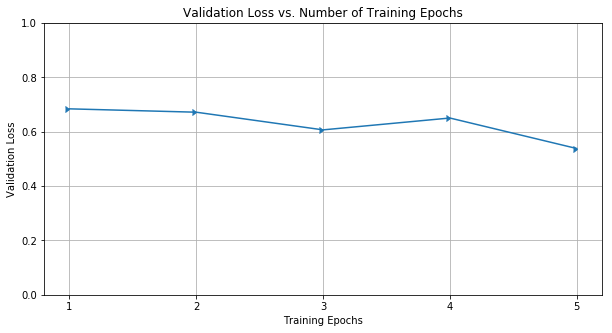

In [25]:
# Training vs Epoch
loss_graph('Training', N_EPOCHS, train_loss_hist, True, 'glove_training_loss.png')

#Validation vs Epoch
loss_graph('Validation', N_EPOCHS, valid_loss_hist, True, 'glove_validation_loss.png')


Plot the Confusion Matrix

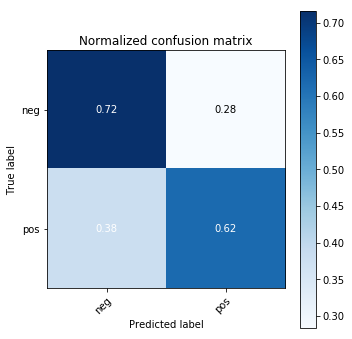

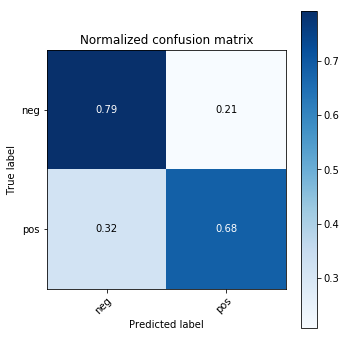

In [26]:
np.set_printoptions(precision=2)

# Plot confusion matrix for Training
plot_confusion_matrix(train_cm, normalize=True, save=True, filename='glove_training_cm.png')

# Plot confusion matrix for Validation
plot_confusion_matrix(valid_cm, normalize=True, save=True, filename='glove_validation_cm.png')


## Test

In [27]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc, test_f1, test_cm = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}  | . Test. F1: {valid_f1*100:.2f} %')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Loss: 0.542 | Test Acc: 73.36  | . Test. F1: 71.95 %


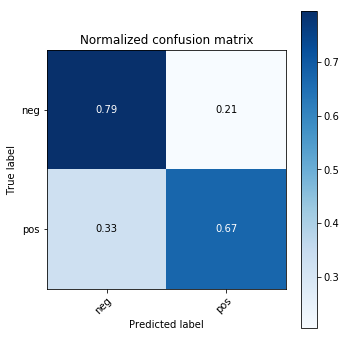

In [28]:
# Plot non-normalized confusion matrix for Training
plot_confusion_matrix(test_cm, normalize=True, save=True, filename='glove_test_cm.png')